In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker, relationship, join
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Table, Column, Integer, ForeignKey
from sqlalchemy.orm import relationship
from aquabyte.optics import convert_to_world_point, depth_from_disp, pixel2world, euclidean_distance

import pickle
from PIL import Image, ImageDraw

pd.set_option('max_columns', 500)
pd.set_option('max_colwidth', 50)

<h1> Establish connection to database and perform query for base dataset </h1>

In [2]:
# AWS credentials
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


# prod SQL credentaials
prod_sql_credentials = json.load(open(os.environ["PROD_SQL_CREDENTIALS"]))
prod_sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(prod_sql_credentials["user"], prod_sql_credentials["password"],
                           prod_sql_credentials["host"], prod_sql_credentials["port"],
                           prod_sql_credentials["database"]))

Session = sessionmaker(bind=prod_sql_engine)
session = Session()
Base = automap_base()
Base.prepare(prod_sql_engine, reflect=True)
KeypointAnnotations = Base.classes.keypoint_annotations
FishDetections = Base.classes.fish_detections



/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.5/dist-packages/sqlalchemy/dialects/postgresql/base.py:2950: SAWarning: Skipped unsupported reflection of expression-based index frames_captured_at_date
  % idx_name)
/usr/local/lib/python3.5/dist-packages/sqlalchemy/dialects/postgresql/base.py:2950: SAWarning: Skipped unsupported reflection of expression-based index lati_fish_detections_detected_at_date
  % idx_name)


In [3]:
# perform join between KeypointAnnotatios and FishDetections

records = session.query(
    KeypointAnnotations, FishDetections
).outerjoin(
    FishDetections, KeypointAnnotations.fish_detection_id == FishDetections.id
).all()



<h1> Iterate over query results and generate 3D coordinates for each stereo fish detection </h1>

In [43]:
df = pd.DataFrame()
for idx, record in enumerate(records):
    if idx % 100 == 0:
        print(idx)
    keypoint_annotation = record.keypoint_annotations
    fish_detection = record.fish_detections
    if (fish_detection.site_id != 23) or (fish_detection.pen_id != 4):
        continue
    keypoints = keypoint_annotation.keypoints
    
    if keypoints:
        if keypoints.get('leftCrop') and keypoints.get('rightCrop'):

            # record image URLs and annotated keypoint coordinates
            left_image_url = fish_detection.left_image_url
            right_image_url = fish_detection.right_image_url
            left_keypoints = keypoints['leftCrop']
            right_keypoints = keypoints['rightCrop']
            
            # compute world coordinates
            camera_metadata = fish_detection.camera_metadata
            camera_metadata['pixelCountHeight'] = 3000
            camera_metadata['pixelCountWidth'] = 4096
            world_keypoint_coordinates = pixel2world(left_keypoints, right_keypoints, camera_metadata)
            
            row = {
                'keypoint_annotation_id': keypoint_annotation.id,
                'fish_detection_id': fish_detection.id,
                'captured_at': fish_detection.captured_at,
                'is_qa': keypoint_annotation.is_qa,
                'left_image_url': left_image_url,
                'right_image_url': right_image_url,
                'left_keypoints': left_keypoints,
                'right_keypoints': right_keypoints,
                'world_keypoint_coordinates': world_keypoint_coordinates,
                'site_id': fish_detection.site_id,
                'pen_id': fish_detection.pen_id,
                'camera_metadata': camera_metadata,
                'left_crop_metadata': fish_detection.left_crop_metadata,
                'right_crop_metadata': fish_detection.right_crop_metadata,
                'keypoints_invalid': False
            }
            
            body_parts = sorted(list(world_keypoint_coordinates.keys()))
            for i in range(len(body_parts)-1):
                for j in range(i+1, len(body_parts)):
                    bp1, bp2 = body_parts[i], body_parts[j]
                    row['{}<->{}'.format(body_parts[i], body_parts[j])] = \
                        euclidean_distance(world_keypoint_coordinates[bp1], world_keypoint_coordinates[bp2])
                    
            keypoints_valid = True
            threshold = 10
            left_keypoint_y_coords = {bp['keypointType']: bp['yFrame'] for bp in left_keypoints}
            right_keypoint_y_coords = {bp['keypointType']: bp['yFrame'] for bp in right_keypoints}
            for bp in body_parts:
                if abs(left_keypoint_y_coords[bp] - right_keypoint_y_coords[bp]) < 10:
                    keypoints_valid = False

            if not keypoints_valid:
                row['keypoints_invalid'] = True
                    
            
            df = df.append(row, ignore_index=True)

df.index = pd.to_datetime(df.captured_at)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

AttributeError: 'NoneType' object has no attribute 'site_id'

In [44]:
df.index = pd.to_datetime(df.captured_at)
invalid_fish_detection_ids = json.load(open('invalid_fish_detection_ids.json'))
mask = (df.is_qa == 1) & (df.site_id == 23) & (df.pen_id == 4) & (df.index >= '2019-04-27') & (~df.fish_detection_id.isin(invalid_fish_detection_ids))


<h1> Pairwise Distance Distributions </h1>

Here, we plot the distributions of the pairwise distance features. This will allow us to visibly spot and potentially diagnose bad biomass estimates, and give more insights as to why the linear PCA model may be failing.

In [26]:
body_parts = sorted([
    'PECTORAL_FIN',
    'EYE',
    'TAIL_NOTCH',
    'DORSAL_FIN',
    'UPPER_LIP',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PELVIC_FIN'
])

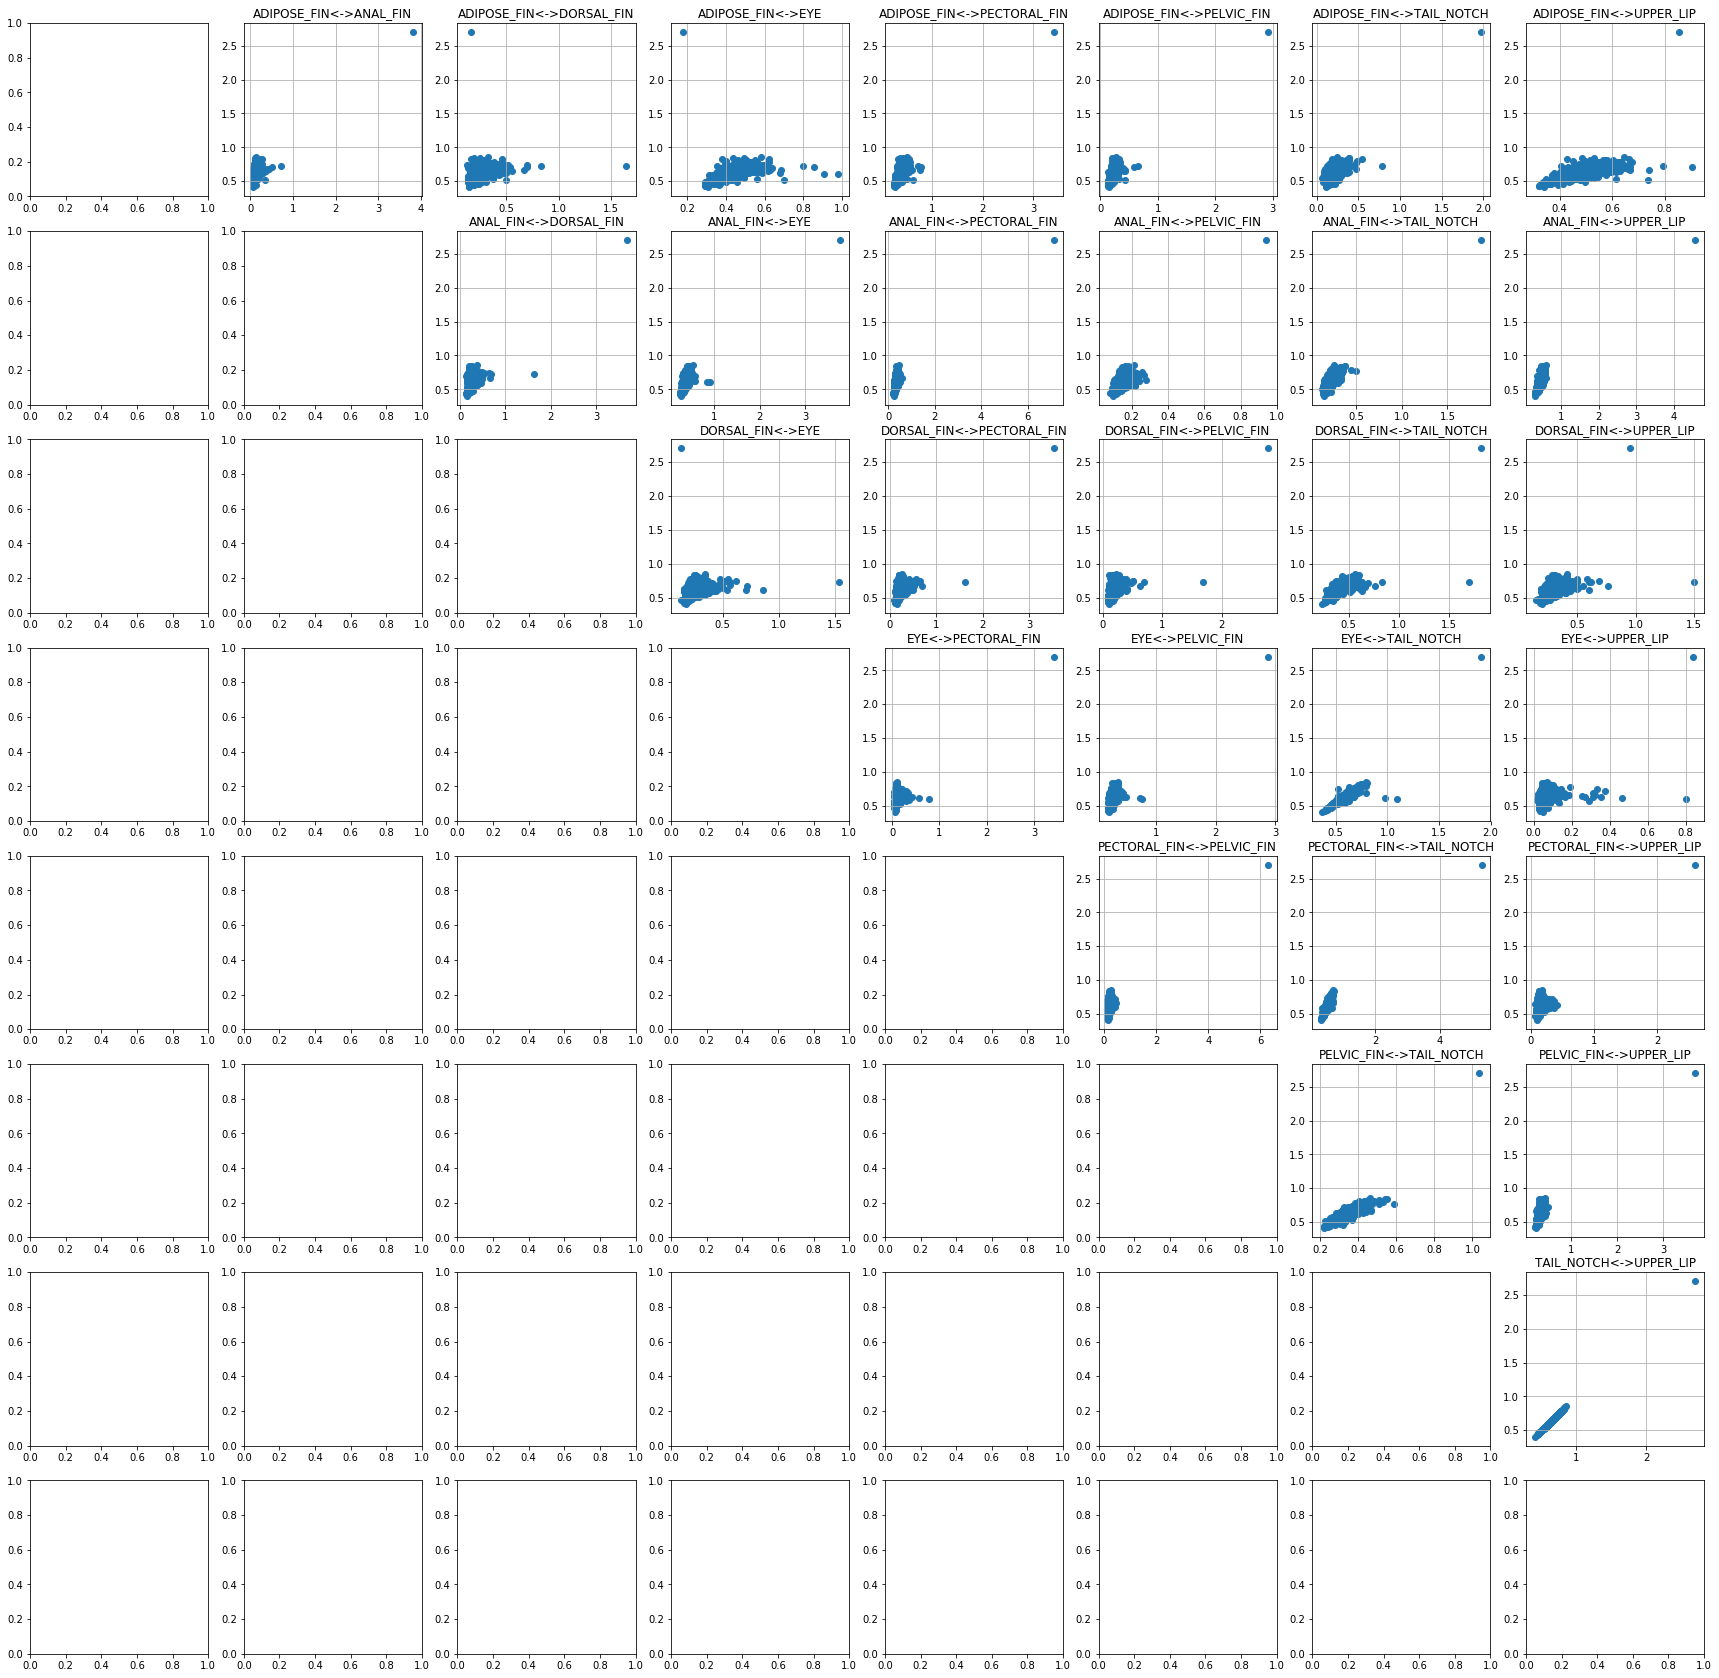

In [45]:
N = len(body_parts)
fig, axes = plt.subplots(N, N, figsize=(30, 30))
i = 1
for i, bp1 in enumerate(body_parts):
    for j, bp2 in enumerate(body_parts):
        if bp1 >= bp2:
            continue
        axes[i, j].scatter(df.loc[mask, '{}<->{}'.format(bp1, bp2)], df.loc[mask, 'TAIL_NOTCH<->UPPER_LIP'])
        axes[i, j].grid()
        axes[i, j].set_title('{}<->{}'.format(bp1, bp2))
        
        

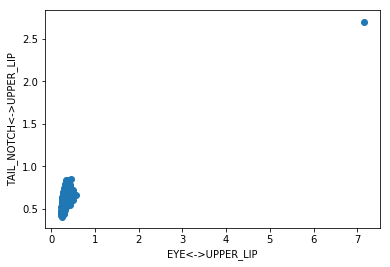

In [46]:
plt.scatter(df.loc[mask, 'ANAL_FIN<->PECTORAL_FIN'], df.loc[mask, 'TAIL_NOTCH<->UPPER_LIP'])
plt.xlabel('EYE<->UPPER_LIP')
plt.ylabel('TAIL_NOTCH<->UPPER_LIP')
plt.show()

In [ ]:
dist_mask = df['EYE<->UPPER_LIP']
df

<h1> Compute biomass estimate using Linear Model + PCA + interaction features for pairwise distances </h1>

In [29]:
def coord2biomass_linear(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - model['mean']) / model['std']
    X_transformed = np.dot(X_normalized, model['PCA_components'].T)
    prediction = np.dot(X_transformed, reg_coef) + reg_intercept
    return prediction


def coord2biomass_blender(world_keypoints, blender):
    """from coordinates to biomass"""

    reverse_mapping = blender["reverse_mapping"]
    distances = np.array(blender["distances"])
    volumes = blender["volume"]
    regression_coeff = blender["coeff"]

    # calculate pairwise distances for production coord
    # the reverse mapping insure that we listing the kp
    # in the same order
    measurements = []
    number_of_parts = len(world_keypoints)
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    measurements = np.array(measurements)

    # absolute diff
    diff = np.nanmean(np.abs(distances - measurements), axis=1)
    closest = np.argmin(diff)
    prediction = volumes[closest]

    # here is some machine learning
    prediction = prediction*regression_coeff[0] + regression_coeff[1]
    return prediction

In [53]:
model = pickle.load(open('./model.pkl', 'rb'))
blender = json.load(open('./volumes.json'))

In [56]:
linear_biomass_values, blender_biomass_values, lengths = [], [], []
i = 0
for idx, row in df.iterrows():
    if i % 10 == 0:
        print(i)
    i += 1
    
    linear_biomass_values.append(coord2biomass_linear(row.world_keypoint_coordinates, model))
    blender_biomass_values.append(coord2biomass_blender(row.world_keypoint_coordinates, blender))
    lengths.append(euclidean_distance(row.world_keypoint_coordinates['UPPER_LIP'], row.world_keypoint_coordinates['TAIL_NOTCH']))
df['predicted_biomass_linear'] = linear_biomass_values
df['predicted_biomass_blender'] = blender_biomass_values
df['length'] = lengths
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [106]:
mask = (df.is_qa == 1) & (df.index > '2019-05-04') & (df.index <= '2019-05-10') & (df.keypoints_invalid == False)
df[mask].sort_values('predicted_biomass_linear', ascending=False)

,ADIPOSE_FIN<->ANAL_FIN,ADIPOSE_FIN<->DORSAL_FIN,ADIPOSE_FIN<->EYE,ADIPOSE_FIN<->PECTORAL_FIN,ADIPOSE_FIN<->PELVIC_FIN,ADIPOSE_FIN<->TAIL_NOTCH,ADIPOSE_FIN<->UPPER_LIP,ANAL_FIN<->DORSAL_FIN,ANAL_FIN<->EYE,ANAL_FIN<->PECTORAL_FIN,ANAL_FIN<->PELVIC_FIN,ANAL_FIN<->TAIL_NOTCH,ANAL_FIN<->UPPER_LIP,DORSAL_FIN<->EYE,DORSAL_FIN<->PECTORAL_FIN,DORSAL_FIN<->PELVIC_FIN,DORSAL_FIN<->TAIL_NOTCH,DORSAL_FIN<->UPPER_LIP,EYE<->PECTORAL_FIN,EYE<->PELVIC_FIN,EYE<->TAIL_NOTCH,EYE<->UPPER_LIP,PECTORAL_FIN<->PELVIC_FIN,PECTORAL_FIN<->TAIL_NOTCH,PECTORAL_FIN<->UPPER_LIP,PELVIC_FIN<->TAIL_NOTCH,PELVIC_FIN<->UPPER_LIP,TAIL_NOTCH<->UPPER_LIP,camera_metadata,captured_at,fish_detection_id,is_qa,keypoint_annotation_id,keypoints_invalid,left_crop_metadata,left_image_url,left_keypoints,pen_id,right_crop_metadata,right_image_url,right_keypoints,site_id,world_keypoint_coordinates,predicted_biomass_linear,predicted_biomass_blender,length
captured_at,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-05 06:38:38.282303+00:00,0.086446,0.225566,0.402727,0.474404,0.189259,0.243843,0.466952,0.235037,0.368790,0.435581,0.136223,0.250422,0.432090,0.239599,0.326154,0.160765,0.423006,0.290313,0.318210,0.244583,0.518107,0.069165,0.320067,0.673752,0.309101,0.354501,0.302972,0.586873,"{'baseline': 0.10019751688037272, 'pixelCountW...",2019-05-05 06:38:38.282303+00:00,292378.0,1.0,17402.0,0.0,"{'mean_luminance': 14.23030198446937, 'quality...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2450, 'yCrop': 130, 'yFrame': 542,...",4.0,"{'mean_luminance': 14.114166248309612, 'qualit...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2183, 'yCrop': 175, 'yFrame': 523,...",23.0,"{'ANAL_FIN': [-0.18363336736811803, 1.47463334...",15389.650556,3698.942509,0.586873
2019-05-07 10:18:44.759568+00:00,0.118892,0.250624,0.497655,0.564478,0.241937,0.206997,0.547498,0.267973,0.462728,0.489192,0.192463,0.224165,0.512464,0.276777,0.450877,0.155474,0.453522,0.328325,0.293705,0.299032,0.676820,0.061814,0.411611,0.674579,0.280515,0.412259,0.356616,0.723225,"{'baseline': 0.10019751688037272, 'pixelCountW...",2019-05-07 10:18:44.759568+00:00,355186.0,1.0,25182.0,0.0,"{'mean_luminance': 14.401287720215164, 'qualit...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 3197, 'yCrop': 550, 'yFrame': 2339...",4.0,"{'mean_luminance': 15.73361524932754, 'quality...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2911, 'yCrop': 535, 'yFrame': 2324...",23.0,"{'ANAL_FIN': [0.2878863437903463, 1.4372332214...",13628.967555,4836.702481,0.723225
2019-05-06 11:27:54.083585+00:00,0.249899,0.222143,0.494909,0.466934,0.269198,0.244087,0.533399,0.358573,0.470402,0.400333,0.179847,0.222035,0.506037,0.319627,0.328408,0.249721,0.452130,0.355247,0.096956,0.305405,0.660201,0.041289,0.238770,0.602736,0.123818,0.368324,0.343870,0.698283,"{'baseline': 0.10019751688037272, 'pixelCountW...",2019-05-06 11:27:54.083585+00:00,332029.0,1.0,21788.0,0.0,"{'mean_luminance': 12.656850971848142, 'qualit...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2292, 'yCrop': 116, 'yFrame': 1032...",4.0,"{'mean_luminance': 12.335386999448234, 'qualit...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2038, 'yCrop': 98, 'yFrame': 1014,...",23.0,"{'ANAL_FIN': [-0.008251560213677752, 1.5555936...",11914.857438,4836.702481,0.698283
2019-05-04 10:38:58.824116+00:00,0.125691,0.324967,0.502975,0.425120,0.256214,0.186519,0.548374,0.359322,0.404106,0.327654,0.148138,0.206107,0.455046,0.501272,0.418167,0.361414,0.510411,0.509694,0.098610,0.258583,0.585928,0.065301,0.180261,0.521866,0.133684,0.343881,0.308735,0.642817,"{'baseline': 0.10019751688037272, 'pixelCountW...",2019-05-04 10:38:58.824116+00:00,274114.0,1.0,16213.0,0.0,"{'mean_luminance': 8.66442279508184, 'qualityS...",https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"[{'xFrame': 2448, 'yCrop': 162, 'yFrame': 2268...",4.0,"{'mean_luminance': 9.551906805772951, 'quality...",https://s3-eu-west-1.amaz

Text(0, 0.5, 'Count')

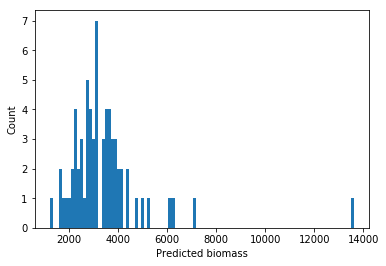

In [97]:
plt.hist(df[mask].predicted_biomass_linear, bins=100)
plt.xlabel('Predicted biomass')
plt.ylabel('Count')

<h1> Examine the worst cases </h1>

In [54]:
mask = (df.is_qa == 1) & (df.index > '2019-05-07') & (df.index <= '2019-05-08')
slice_mask = (df.predicted_biomass_blender > 4836) & (df.predicted_biomass_blender < 4837)
for idx, row in df[mask & slice_mask].iterrows():
    world_keypoint_coordinates = row.world_keypoint_coordinates
    d = euclidean_distance(world_keypoint_coordinates['UPPER_LIP'], world_keypoint_coordinates['TAIL_NOTCH'])
#     print('Length: {}'.format(d))
    if d > 0.99:
        print(idx, row.fish_detection_id)

2019-05-07 11:13:57.162318+00:00 356989.0


In [41]:
world_keypoint_coordinates

{'ADIPOSE_FIN': array([0.18369545, 1.001708  , 0.04550823]),
 'ANAL_FIN': array([0.28044414, 1.07792492, 0.00489708]),
 'DORSAL_FIN': array([ 0.12949023,  1.08381522, -0.19476527]),
 'EYE': array([ 0.18691199,  1.0466395 , -0.43481371]),
 'PECTORAL_FIN': array([ 0.23476358,  1.0466395 , -0.36031951]),
 'PELVIC_FIN': array([ 0.28093527,  1.08086204, -0.15276877]),
 'TAIL_NOTCH': array([0.29445801, 1.01192951, 0.20304564]),
 'UPPER_LIP': array([ 0.17898296,  1.08678457, -0.48522993])}

In [77]:
def plot_coordinates(image_url, side, keypoints):
    image_f = './image.jpg'
    bucket = 'aquabyte-crops'
    key = image_url[image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(bucket, key, image_f)
    plt.figure(figsize=(30, 10))
    im = plt.imread(image_f)
    
    for keypoint in keypoints:
        keypoint_type = keypoint['keypointType']
        x, y = keypoint['xCrop'], keypoint['yCrop']
        plt.scatter([x], [y])
        plt.annotate(keypoint_type, (x, y), color='red')
        
    plt.imshow(im)        
    

0.5868730032589633


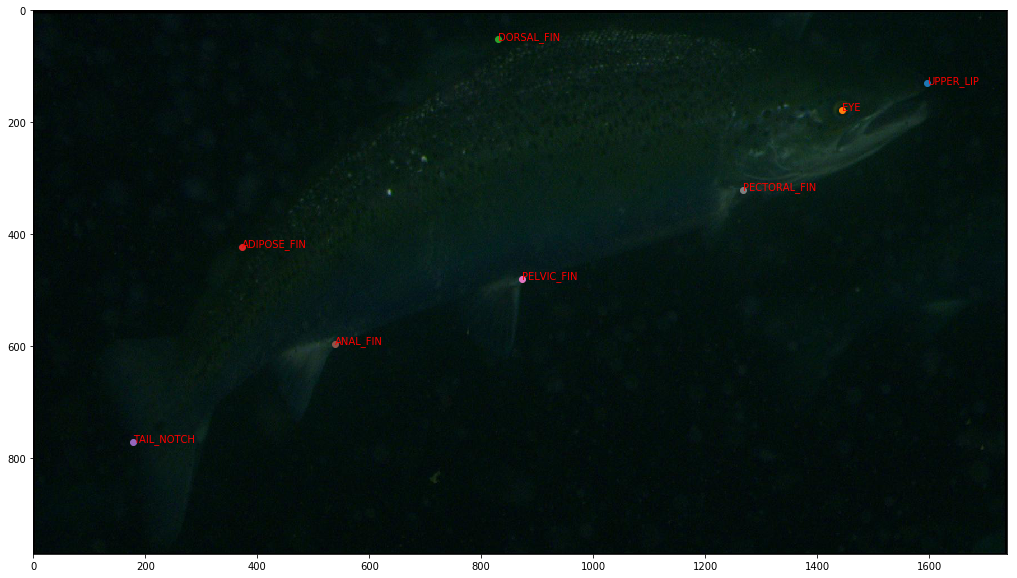

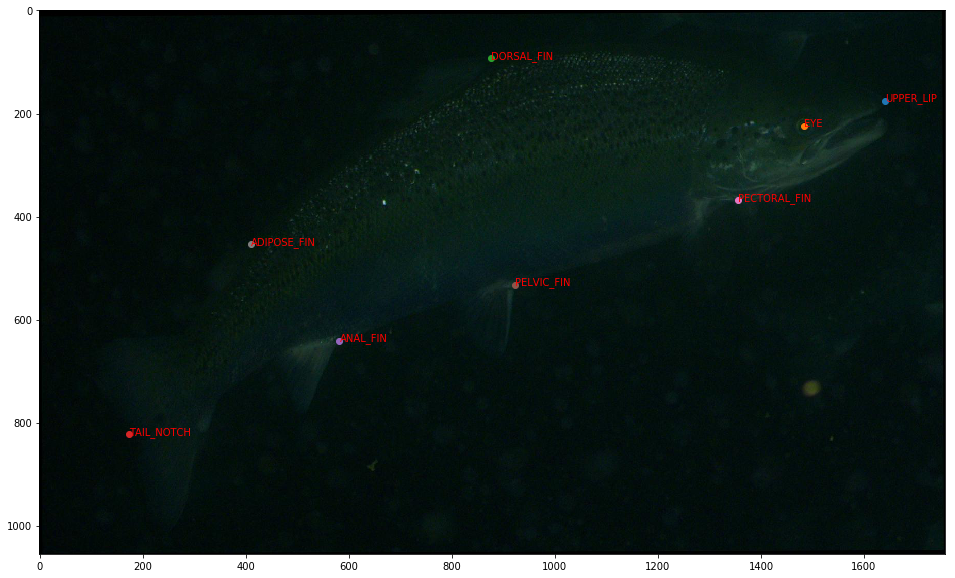

In [107]:
fish_detection_id = 292378
fish_id_mask = (df.fish_detection_id == fish_detection_id) & (df.is_qa == 1)
left_image_url = df[fish_id_mask].left_image_url.iloc[0]
left_keypoints = df[fish_id_mask].left_keypoints.iloc[0]
right_image_url = df[fish_id_mask].right_image_url.iloc[0]
right_keypoints = df[fish_id_mask].right_keypoints.iloc[0]

world_keypoint_coordinates = df[fish_id_mask].world_keypoint_coordinates.iloc[0]
print(euclidean_distance(world_keypoint_coordinates['UPPER_LIP'], world_keypoint_coordinates['TAIL_NOTCH']))
plot_coordinates(left_image_url, 'left', left_keypoints)
plot_coordinates(right_image_url, 'right', right_keypoints)

In [79]:
x = {"width": 3362, "height": 1348, "x_coord": 734, "y_coord": 1362, "crop_area": 4531976, "qualityScore": {"quality": 0.003544951556250453, "darkness": 0.980517566204071, "modelInfo": {"model": "Mobilenet", "input_size": [224, 224, 3], "description": "binary classification good / bad for filtering", "output_size": [3], "probability": {"is_dark": 2, "is_good": 0, "is_blurry": 1}}, "blurriness": 0.016313577070832253}, "mean_luminance": 51.980444071195436}

In [78]:
x

{'crop_area': 4815540,
 'height': 1395,
 'mean_luminance': 50.03763378561906,
 'qualityScore': {'blurriness': 0.016313577070832253,
  'darkness': 0.980517566204071,
  'modelInfo': {'description': 'binary classification good / bad for filtering',
   'input_size': [224, 224, 3],
   'model': 'Mobilenet',
   'output_size': [3],
   'probability': {'is_blurry': 1, 'is_dark': 2, 'is_good': 0}},
  'quality': 0.003544951556250453},
 'width': 3452,
 'x_coord': 150,
 'y_coord': 1350}

In [80]:
x

{'crop_area': 4531976,
 'height': 1348,
 'mean_luminance': 51.980444071195436,
 'qualityScore': {'blurriness': 0.016313577070832253,
  'darkness': 0.980517566204071,
  'modelInfo': {'description': 'binary classification good / bad for filtering',
   'input_size': [224, 224, 3],
   'model': 'Mobilenet',
   'output_size': [3],
   'probability': {'is_blurry': 1, 'is_dark': 2, 'is_good': 0}},
  'quality': 0.003544951556250453},
 'width': 3362,
 'x_coord': 734,
 'y_coord': 1362}

In [151]:
df['2019-05-02']['predicted_biomass_blender'].mean()

3695.6892990752403

In [284]:
mask = (df.site_id == 23) & (df.pen_id == 4) & (df.index >= '2019-04-27')
df[mask].predicted_biomass_blender.resample('D', how=lambda x: x.mean())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


captured_at
2019-04-27 00:00:00+00:00    3364.401708
2019-04-28 00:00:00+00:00    3444.337160
2019-04-29 00:00:00+00:00    3476.644612
2019-04-30 00:00:00+00:00    3441.859915
2019-05-01 00:00:00+00:00    3424.173085
2019-05-02 00:00:00+00:00    3614.478289
Freq: D, Name: predicted_biomass_blender, dtype: float64

(array([  3.,  22.,  71., 242., 298., 367., 206.,  77.,  32.,  11.]),
 array([ 667.76812834, 1215.38346234, 1762.99879634, 2310.61413034,
        2858.22946434, 3405.84479834, 3953.46013234, 4501.07546634,
        5048.69080034, 5596.30613434, 6143.92146833]),
 <a list of 10 Patch objects>)

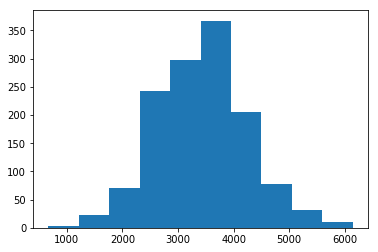

In [280]:
plt.hist(df[mask].predicted_biomass_blender)

In [232]:
df[mask].shape

(1329, 14)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


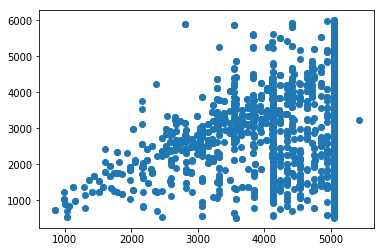

In [173]:
mask = (df.predicted_biomass_linear > 500) & (df.predicted_biomass_linear < 6000)
plt.scatter(df.ix[mask, 'predicted_biomass_blender'], df.ix[mask, 'predicted_biomass_linear'])
plt.show()

<h1> Examine rectification issue </h1>

In [117]:
df.shape

(50273, 11)

In [3]:
df = pd.read_csv('./data_dump.csv')

In [ ]:
rectified_bucket = 'aquabyte-crops'
left_image_rectified_f = './left_image_rectified.jpg'
right_image_rectified_f = './right_image_rectified.jpg'

invalid_fish_detection_ids, invalid_urls = [], []
i = 0
for idx, row in df.iterrows():
    if i % 100 == 0:
        print(i)
    i += 1
    if i < 36132:
        continue
    left_image_url = row.left_image_url
    right_image_url = row.right_image_url
    left_rectified_key = left_image_url[left_image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(rectified_bucket, left_rectified_key, left_image_rectified_f)
    right_rectified_key = right_image_url[right_image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(rectified_bucket, right_rectified_key, right_image_rectified_f)
    
    # this is dumb, can probably do this in memory
    left_rectified_image = cv2.imread(left_image_rectified_f)
    right_rectified_image = cv2.imread(right_image_rectified_f)
    
    left_crop_metadata = json.loads(row.left_crop_metadata)
    right_crop_metadata = json.loads(row.right_crop_metadata)
    left_crop_width = left_crop_metadata['width']
    left_crop_height = left_crop_metadata['height']
    right_crop_width = right_crop_metadata['width']
    right_crop_height = right_crop_metadata['height']
    
    invalid = False
    if left_rectified_image.shape[0] == left_crop_height and left_rectified_image.shape[1] == left_crop_width:
        invalid = True
        invalid_urls.append(left_image_url)
        print('left image not rectified for id {}!'.format(row.id))
    if right_rectified_image.shape[0] == right_crop_height and right_rectified_image.shape[1] == right_crop_width:
        invalid = True
        invalid_urls.append(right_image_url)
        print('right image not rectified for id {}!'.format(row.id))
    
    if invalid:
        invalid_fish_detection_ids.append(int(row.id))
    
    
    
        
    
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

left image not rectified for id 347928!
left image not rectified for id 348096!
42800
left image not rectified for id 348469!
left image not rectified for id 348658!
left image not rectified for id 348722!
left image not rectified for id 348747!
left image not rectified for id 348761!
left image not rectified for id 348783!
42900
left image not rectified for id 348883!
left image not rectified for id 348884!
left image not rectified for id 349035!
left image not rectified for id 349065!
left image not rectified for id 349178!
left image not rectified for id 349297!
43000
left image not rectified for id 349675!
left image not rectified for id 349719!
left image not rectified for id 349986!
43100
left image not rectified for id 350336!
43200
left image not rectified for id 350562!
left image not rectified for id 350808!
43300
left image not rectified for id 351129!
43400
left image not rectified for id 351427!
left image not rectified for id 351453!
left image not rectified for id 351499

In [104]:
pickle.dump(invalid_ids, open('./invalid_ids', 'wb'))

In [20]:
i

36132

In [31]:
json.dump(invalid_urls + invalid_urls_old, open('./invalid_urls.json', 'w'))

In [29]:
invalid_urls_old = json.load(open('./invalid_urls.json'))

In [30]:
invalid_fish_detection_ids_old = json.load(open('./invalid_fish_detection_ids.json'))

In [32]:
json.dump(invalid_fish_detection_ids + invalid_fish_detection_ids_old, open('./invalid_fish_detection_ids.json', 'w'))